<a href="https://colab.research.google.com/github/zachfreitas/ADS_504_Machine_Learning/blob/main/Module_4/Assignment_4/Assignment_Guide_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 4.1
Zachariah Freitas

# Clothing Data

For this assignment, you will work with data from a popular clothing website, modcloth.com. This
gives us a chance to work with feature engineering, feature extraction, and unbalanced,
multiclass datasets. You will train several different classification models based on different types
of data from this dataset.

As you go through the assignment, you will create several tables and figures. After you
complete the programming section, use the tables and figures you generated to answer the questions.


In [2]:
# All you may need as the IMPORTS :)
import pandas as pd
import numpy as np
import json
import os
import matplotlib.pyplot as plt
import seaborn as sns
import json
# This ensures that sklearn 0.24 is loaded on Google colab
#!pip uninstall scikit-learn -y
#!pip install -U scikit-learn

from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, LabelEncoder, StandardScaler, Normalizer
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import confusion_matrix, accuracy_score, plot_confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.linear_model import Perceptron

# Pre-Processing and Loading Data:

In your Blackboard assignment prompt is the modcloth_final_data.json file, which is a series of
JSON objects from a popular clothing store, modcloth.com. Load these objects into a list, and
then use pd.DataFrame to convert that list into a dataframe called modcloth_data.


In [3]:
df = pd.read_json(
    'https://github.com/zachfreitas/ADS_504_Machine_Learning/raw/main/Module_4/Assignment_4/modcloth_final_data.zip',
     lines = True
     )
df.head()

modcloth = pd.DataFrame(df)
# remove rows with null quality values
modcloth = modcloth[modcloth['quality'].notna()]
# remove bust outlier
modcloth = modcloth[modcloth['bust'] != '37-39']

modcloth.head()

,item_id,waist,size,quality,cup size,hips,bra size,category,bust,height,user_name,length,fit,user_id,shoe size,shoe width,review_summary,review_text
0,123373,29.0,7,5.0,d,38.0,34.0,new,36,5ft 6in,Emily,just right,small,991571,NaN,NaN,NaN,NaN
1,123373,31.0,13,3.0,b,30.0,36.0,new,NaN,5ft 2in,sydneybraden2001,just right,small,587883,NaN,NaN,NaN,NaN
2,123373,30.0,7,2.0,b,NaN,32.0,new,NaN,5ft 7in,Ugggh,slightly long,small,395665,9.0,NaN,NaN,NaN
3,123373,NaN,21,5.0,dd/e,NaN,NaN,new,NaN,NaN,alexmeyer626,just right,fit,875643,NaN,NaN,NaN,NaN
4,123373,NaN,18,5.0,b,NaN,36.0,new,NaN,5ft 2in,dberrones1,slightly long,small,944840,NaN,NaN,NaN,NaN


In [5]:
modcloth.describe().T

,count,mean,std,min,25%,50%,75%,max
item_id,82721.0,469317.955912,213997.525023,123373.0,314980.0,454030.0,658440.0,807722.0
waist,2842.0,31.323716,5.291110,20.0,28.0,30.0,34.0,50.0
size,82721.0,12.661585,8.271349,0.0,8.0,12.0,15.0,38.0
quality,82721.0,3.949046,0.992782,1.0,3.0,4.0,5.0,5.0
hips,56030.0,40.358058,5.827110,30.0,36.0,39.0,43.0,60.0
bra size,76722.0,35.972237,3.224544,28.0,34.0,36.0,38.0,48.0
user_id,82721.0,498817.452908,286379.634536,6.0,252860.0,497769.0,744746.0,999972.0
shoe size,27885.0,8.145060,1.324220,5.0,7.0,8.0,9.0,11.5


In [6]:
modcloth.isna().sum().T

item_id               0
waist             79879
size                  0
quality               0
cup size           6231
hips              26691
bra size           5999
category              0
bust              70889
height             1103
user_name             0
length               25
fit                   0
user_id               0
shoe size         54836
shoe width        64134
review_summary     6722
review_text        6722
dtype: int64

Create a variable named ‘labels’ using the ‘quality’ column. These are the labels that we will use
for the rest of this assignment.

Next, you will transform these data into numerical vectors you can use for classification.
For the variables ‘waist’, ’size’, ’hips’, ‘bra size’, and ‘shoe size’ you can use
pd.to_numeric(modcloth_data[variable] to convert them to numerical values. Store
these in a data frame.


For the next variable, ‘height’, the strings need some processing to convert them into numeric
values. You can use pd.apply to apply a transformation to the column of the data frame. Write a
short python function to convert these to a meaningful categorical variable: convert the strings to
height (in inches). Also, do this for the variable ‘bust’ - there are some outliers that could be handled by writing and applying another python function. Convert height and bust and store the
numeric values to the same data frame as the other numeric features.


In [14]:
# Feel free to have you own function(s). Here is a suggestion for you to get an idea 

def conv_height(x):
    if pd.isnull(x):
        return x
    spt = x.split(' ')
    ft = int(spt[0].split('ft')[0])
    inch = 0
    if len(spt) > 1:
        inch = int(spt[1].split('in')[0])
    return (ft * 12) + inch
    
def conv_bust(x):
    if pd.isnull(x):
        return x
    spt = x.split('-')
    # if range, split the difference
    if len(spt) > 1:
        return (int(spt[1]) - int(spt[0]) // 2) + int(spt[0])
    return int(spt[0])

In [15]:
labels = modcloth['quality']
# Convert waist, size, hips, bra size, shoe size to numeric:
num_cols = ['waist','size','hips','bra size','shoe size']

# store to dataframe
num_df = pd.DataFrame()
num_df[num_cols] = modcloth[num_cols].apply(pd.to_numeric, errors='coerce')
# Convert height
num_df['height (inch)'] = modcloth['height'].apply(conv_height)
# Convert bust
num_df['bust (inch)'] = modcloth['bust'].apply(conv_bust)

Plot the height using seaborn’s distplot function. You should see a normal distribution of height,
which should match your expectations for what the distribution of human heights should look
like.


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


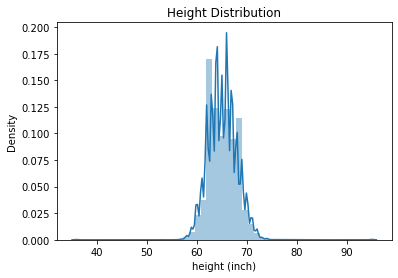

In [21]:
sns.distplot(num_df['height (inch)'])
plt.title('Height Distribution')
plt.show();

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


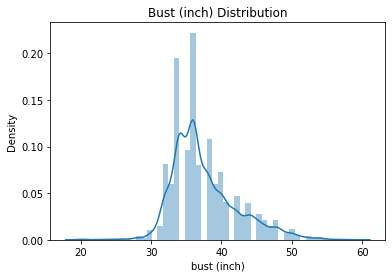

In [23]:
#Plot 'bust (inch)' here
sns.distplot(num_df['bust (inch)'])
plt.title('Bust (inch) Distribution')
plt.show();

Make a plot of the waist data, which should look like this:


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


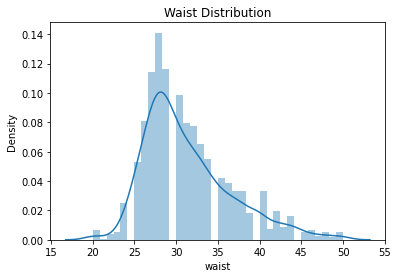

In [22]:
#Plot Waist data here
sns.distplot(num_df['waist'])
plt.title('Waist Distribution')
plt.show();

# Categorical Data for Reviews

For these values, ‘cup size’, ‘length’, ‘category’, use OneHotEncoder to convert these to a data
frame called cat_feat.
Use make_pipeline to compare these two classifiers: 



```
balanced_model = make_pipeline(,Perceptronclass_weight='balanced'))
unbalanced_model = make_pipeline(,Perceptron())
```




Train a classifier using the data in cat_feat. Use train_test_split and test_size=0.50 to get a
50/50 train and test split.
Use metrics.plot_confusion_matrix and metrics.classification_report to report and visualize the
confusion matrix and results. Perform this for both the balanced and unbalanced models.

In [ ]:
# one-hot encode
# cat_feat = modcloth[[...]]
# train_test_split here

balanced_model = make_pipeline(OneHotEncoder(),Perceptron(class_weight='balanced'))
unbalanced_model = make_pipeline(OneHotEncoder(), Perceptron())

# fit the models here:

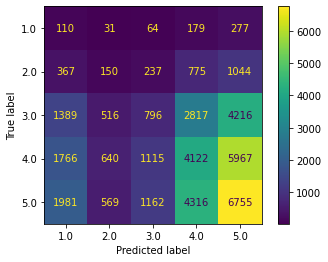

In [ ]:
#Plot Balanced here

In [ ]:
#print classification_report balanced here

In [ ]:
#Plot unBalanced here

In [ ]:
#print classification_report Unbalanced here

              precision    recall  f1-score   support

         1.0       0.06      0.02      0.03       661
         2.0       0.05      0.02      0.03      2573
         3.0       0.24      0.14      0.17      9734
         4.0       0.33      0.35      0.34     13610
         5.0       0.37      0.51      0.43     14783

    accuracy                           0.33     41361
   macro avg       0.21      0.21      0.20     41361
weighted avg       0.30      0.33      0.31     41361



# Categorical and Numeric Features
Next, you will add in data from the numeric features. Unfortunately, many of these values are
missing: not every JSON object will have a value for this numeric value. 


In [ ]:
comb_df = pd.merge(cat_feat, num_df[num_df.index.isin(cat_feat.index)],left_index=True, right_index=True)
#train_test_split here

categorical = ['cup size', 'length', 'category']
numerical = ['waist', 'size', 'hips', 'bra size', 'shoe size', 'height (inch)','bust (inch)']

# Pipelines


You will use imputation
as implemented in https://scikit-learn.org/stable/modules/impute.html to fill in the missing values
before classification: **use SimpleImputer.**


Next, you will create three pipelines. Create one pipeline using SimpleImputer to impute the missing
values and the balanced perceptron. 


Next, create a pipeline using **preprocessing.Normalizer()**.

Finally, create a different pipeline using preprocessing.**StandardScaler()**.

For each of the pipeline,l do fivefold cross-validation, using
**scores = cross_val_score(model, X, y, cv=5,scoring=’accuracy’)**

to compute the accuracy of each of the pipelines.
Create a table, with a row (labeled) for each pipeline you created. 


In [ ]:
# Categorical pipeline
cat_pipe = Pipeline([('encoder', OneHotEncoder(handle_unknown='ignore',sparse=False))])

# Simple Imputer pipeline
impute_pipe = Pipeline([('imputer', SimpleImputer(missing_values=np.nan,strategy='median'))])
impute_model = make_pipeline(ColumnTransformer([('cat', cat_pipe, categorical),('num', impute_pipe, numerical)]),Perceptron(class_weight='balanced'))

# Normalize pipeline:


# Standardize pipeline:

In [ ]:
#impute_scores = 
#norm_scores = 
#std_scores = 

# Model Accuracy


The table should report the
*maximum*, *minimum*, and *mean* of accuracy for each of the pipelines.

In [ ]:
#all_scores = 

# pd.DataFrame(all_scores)

# Text Data from Reviews

Finally, you will use the words in the consumer reviews to build a classifier to predict the results.
*corpus = modcloth_data['review_text']*

Create a new variable from the text data, after removing outliers, which are records that contain
no text data (these will be nans in your data frame). This new variable is a list of strings, where
every string is a consumer review.



In [ ]:
#corpus = modcloth['review_text']

# Remove Outliers (records with no text data nans):

#corpus.describe()

**TfidfVectorizer**

Pass this new variable to sklearn’sTfidfVectorizer
(https://scikit-learn.org/stable/modules/feature_extraction.html#text-feature-extraction) to load
the data. Create a new dataframe called X from the bag of words features, using
*pd.DataFrame.sparse.from_spmatrix*, and subset the labels to only those which have text data
present.



**Feature Selection - Top 10**

Next, use feature selection
(https://scikit-learn.org/stable/modules/feature_selection.html#feature-selection) to subset the
text data to only the most relevant features. Be sure to do this based on the training set, then
apply the transformation to the test set. Using the pipeline can make this step easier.

Use *SelectKBest* and *chi-2* to select features. Make sure you have the latest version (at least
0.24 of scikit-learn, or you may get errors). 

Print a list of the top ten features selected. Hint: Use
*vectorizer.get_feature_names(), XKBest.fit()* and then *XNew.get_support()*.




In [ ]:
# Check out the shared link for the "TfidfVectorizer" and review 6.2.3.3. Common Vectorizer usage
# Use the function here 
#spmat = fit_transform here 
#feat_names = get_feature_names here

#X = pd.DataFrame.sparse.from_spmatrix(spmat, columns=feat_names)
#train_test_split here

In [ ]:
# Check out the shared link about FS and review 1.13.2. Univariate feature selection

#print('Top 10 features %s' % Xtrain.columns[kbest.get_support()].tolist())

**Accuracy**

For k in the range [10,25,50,100,250,500,1000,10000], plot the accuracy of the
classifier for each value of k. 

In [ ]:
k_vals = [10,25,50,100,250,500,1000,10000]
results = []
for k in k_vals:
    
    # print('Top 10 features at k=%d %s' % (k, Xtrain.columns[kbest.get_support()].tolist()))
    # X_new has k best features:


    # Test Accuracy using kbest features from training:

    results.append({'k-value': k, 'Training Accuracy': train_acc, 'Test Accuracy':test_acc})

In [ ]:
results_df = pd.DataFrame(results)
results_df

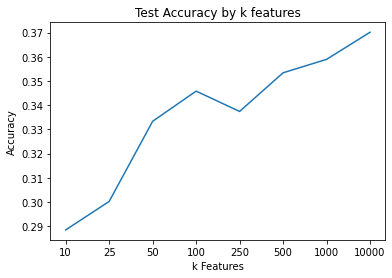

In [ ]:
#Plot it here